In [49]:
# Import our dependencies
import pandas as pd
import sklearn as skl
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from scipy import stats

# Loading Data

In [50]:
# Import dataset
census_df = pd.read_csv('Data/Five_Year_Data.csv')

In [51]:
census_df.describe()[1:].T.style.background_gradient(cmap='YlOrRd')

,mean,std,min,25%,50%,75%,max
Below_9th_grade,56918.918329,205161.825643,0.000000,2361.000000,12156.000000,34748.000000,6922061.000000
9_12th_grade,5.291043,3.726868,0.000000,2.600000,4.300000,6.800000,41.200000
High_School_Grad,13.063994,11.522207,0.000000,5.700000,8.400000,13.500000,55.600000
Some_College,31.577193,8.395277,6.500000,25.000000,32.000000,37.900000,57.400000
Associate's_degree,19.015818,6.227962,1.100000,15.900000,20.300000,23.300000,45.200000
Bachelor's_degree,10.323388,4.014004,0.100000,7.800000,9.600000,12.000000,48.000000
Graduate_degree,13.278605,6.216281,0.600000,8.800000,12.400000,16.800000,45.700000
Population (16+),83349.850316,265688.847797,300.000000,8851.000000,20941.000000,54690.000000,8123894.000000
Employed,49625.999169,162863.855225,154.000000,4561.000000,10965.000000,30366.000000,4929863.000000
Median Household Income,56280.708554,15459.916119,17109.000000,46110.000000,54061.000000,63379.000000,170463.000000


In [52]:
# Modifying census_df to to exclude certain categorical columns
census_df = census_df.drop(columns=['GEO_ID','County','State', 'Year'])
census_df.columns

Index(['Below_9th_grade', '9_12th_grade', 'High_School_Grad', 'Some_College',
       'Associate's_degree', 'Bachelor's_degree', 'Graduate_degree',
       'Population (16+)', 'Employed', 'Median Household Income',
       'Per capita Income', 'Unemployment Rate', 'Professional (Occupation)',
       'Service (Occupation)', 'Sales (Occupation)',
       'Construction (Occupation)', 'Production (Occupation)',
       'Salary (Class)', 'Gov't (Class)', 'Self-employed (Class)',
       'Fam-unpaid (Class)', 'Poverty', 'Child-poverty', 'Median Home value',
       'Median Mortgage', 'Median Rent', 'Total Population', 'White', 'Black',
       'American Indian', 'Asian', 'Pacific Islander', 'Hispanic/Latino'],
      dtype='object')

In [53]:
census_df[['Total Population','Population (16+)','Employed','Below_9th_grade','Poverty']].describe()[1:].T.style.background_gradient(cmap='YlOrRd')

,mean,std,min,25%,50%,75%,max
Total Population,104081.009327,332160.066769,346.000000,10998.000000,25880.000000,68123.000000,10098052.000000
Population (16+),83349.850316,265688.847797,300.000000,8851.000000,20941.000000,54690.000000,8123894.000000
Employed,49625.999169,162863.855225,154.000000,4561.000000,10965.000000,30366.000000,4929863.000000
Below_9th_grade,56918.918329,205161.825643,0.000000,2361.000000,12156.000000,34748.000000,6922061.000000
Poverty,14.824743,6.220637,1.700000,10.400000,13.900000,18.100000,59.000000


In [54]:
# Convert 'Population (16+)','Employed', and 'Below_9th_grade' to percentage of Total Population
convert = ['Population (16+)','Employed','Below_9th_grade']
census_df[convert] = census_df[convert].div(census_df['Total Population'], axis='index')*100

In [55]:
# Combine Asian, Pacific Islander, and American to other
census_df['RaceOther'] = census_df['Asian'] + census_df['Pacific Islander'] + census_df['American Indian']
census_df = census_df.drop(['Asian', 'Pacific Islander','American Indian'], axis=1)

In [56]:
census_df.head()

,Below_9th_grade,9_12th_grade,High_School_Grad,Some_College,Associate's_degree,Bachelor's_degree,Graduate_degree,Population (16+),Employed,Median Household Income,...,Poverty,Child-poverty,Median Home value,Median Mortgage,Median Rent,Total Population,White,Black,Hispanic/Latino,RaceOther
0,0.004710,8.7,32.6,20.3,8.1,15.9,11.8,78.565217,43.702899,58786.0,...,15.4,22.7,147900.0,1176.0,966.0,55200,76.9,19.1,2.8,1.4
1,0.001297,7.0,27.6,22.0,9.4,20.7,10.6,80.589312,44.870667,55962.0,...,10.6,13.4,189800.0,1359.0,958.0,208107,86.3,9.5,4.5,1.5
2,0.031805,18.8,35.7,18.1,7.0,7.8,4.4,81.250485,33.822046,34186.0,...,28.9,47.6,92900.0,950.0,590.0,25782,47.4,47.6,4.3,0.7
3,0.025303,11.1,47.3,18.6,5.8,7.6,3.9,81.990500,35.952413,45340.0,...,14.0,20.2,96500.0,1093.0,714.0,22527,76.7,22.3,2.4,0.2
4,0.013011,12.4,34.0,21.4,12.0,8.1,4.5,79.651314,37.030098,48695.0,...,14.4,21.6,124700.0,1100.0,662.0,57645,95.5,1.5,9.1,0.5


In [57]:
# to move the target column to the last
cols = list(census_df.columns.values)
cols.pop(cols.index('Poverty')) 
census_df = census_df[cols+['Poverty']]
census_df.head()

,Below_9th_grade,9_12th_grade,High_School_Grad,Some_College,Associate's_degree,Bachelor's_degree,Graduate_degree,Population (16+),Employed,Median Household Income,...,Child-poverty,Median Home value,Median Mortgage,Median Rent,Total Population,White,Black,Hispanic/Latino,RaceOther,Poverty
0,0.004710,8.7,32.6,20.3,8.1,15.9,11.8,78.565217,43.702899,58786.0,...,22.7,147900.0,1176.0,966.0,55200,76.9,19.1,2.8,1.4,15.4
1,0.001297,7.0,27.6,22.0,9.4,20.7,10.6,80.589312,44.870667,55962.0,...,13.4,189800.0,1359.0,958.0,208107,86.3,9.5,4.5,1.5,10.6
2,0.031805,18.8,35.7,18.1,7.0,7.8,4.4,81.250485,33.822046,34186.0,...,47.6,92900.0,950.0,590.0,25782,47.4,47.6,4.3,0.7,28.9
3,0.025303,11.1,47.3,18.6,5.8,7.6,3.9,81.990500,35.952413,45340.0,...,20.2,96500.0,1093.0,714.0,22527,76.7,22.3,2.4,0.2,14.0
4,0.013011,12.4,34.0,21.4,12.0,8.1,4.5,79.651314,37.030098,48695.0,...,21.6,124700.0,1100.0,662.0,57645,95.5,1.5,9.1,0.5,14.4


# Visualization

<Axes: >

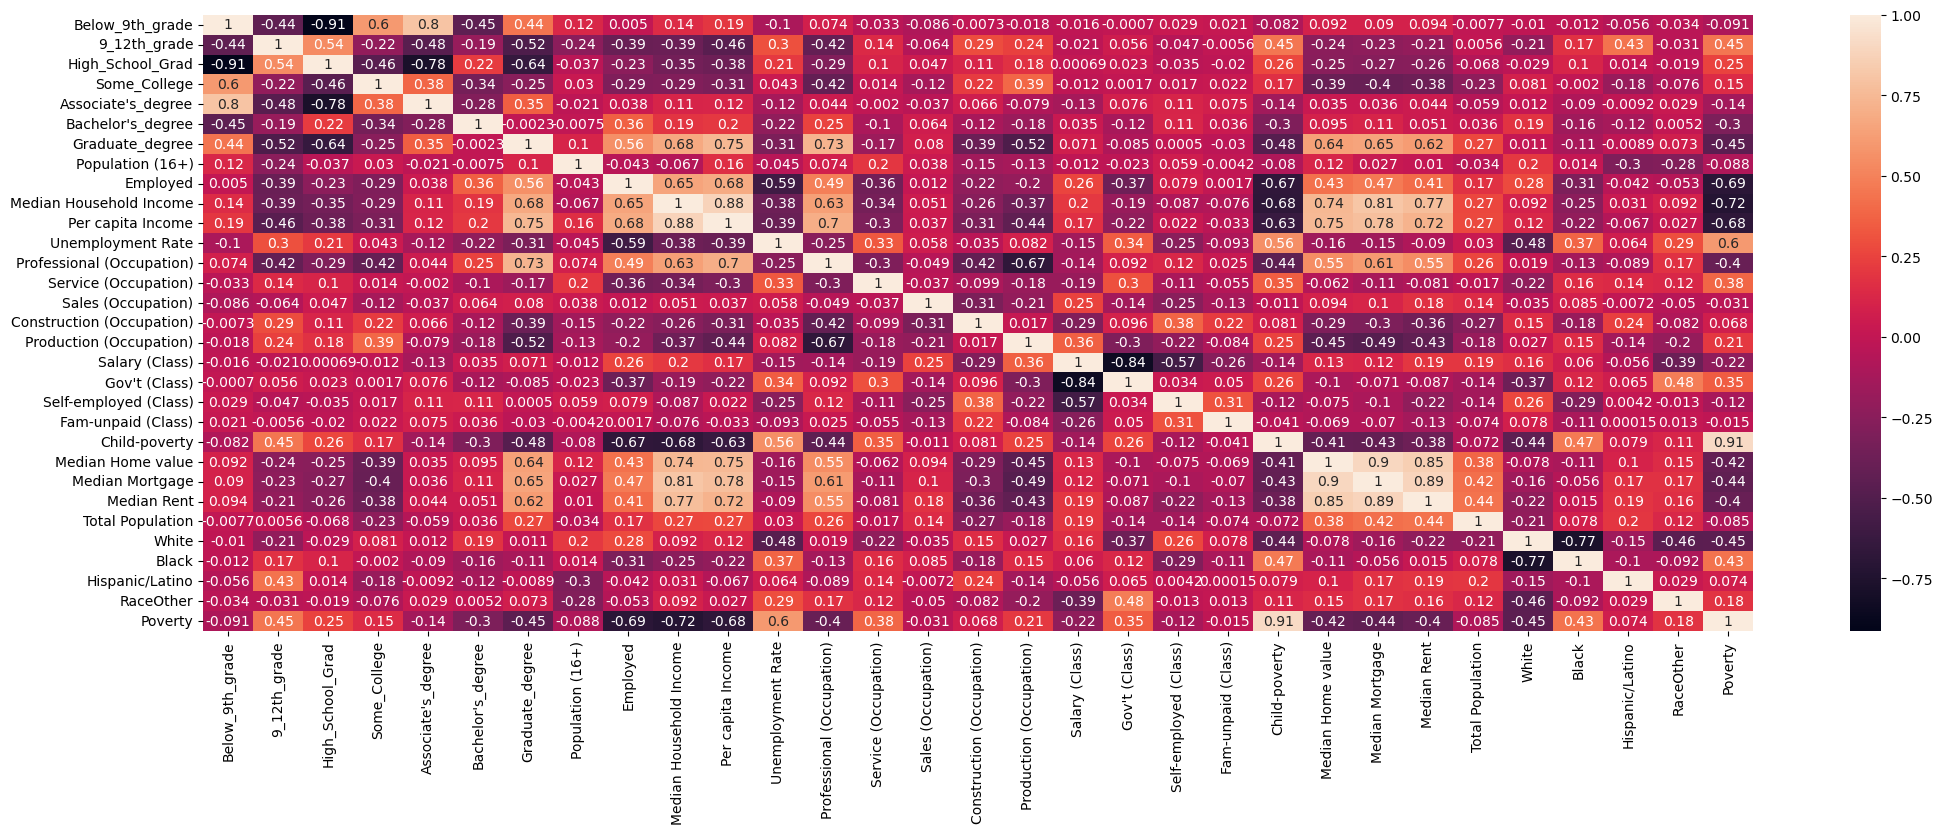

In [58]:
# Correlation Matrix
plt.figure(figsize =(25,8))
sns.heatmap(census_df.corr(),annot=True)

# Splitting the data into train and test sets

In [59]:
# Setting Target Variable
X = census_df.drop(columns=['Poverty'])
y = census_df['Poverty']

# Using sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# PCA

In [241]:
from sklearn.decomposition import PCA
components = 17
pca = PCA(n_components = components)
pca_X_train = pca.fit_transform(X_train_scaled)
pca_X_test = pca.transform(X_test_scaled)

In [242]:
X_train_scaled.shape

(11739, 17)

In [243]:
pca.explained_variance_ratio_.cumsum()

array([0.25952213, 0.38461755, 0.49866134, 0.59249307, 0.65288744,
       0.69895703, 0.73666406, 0.77023069, 0.79861222, 0.825685  ,
       0.85072855, 0.87352482, 0.89120968, 0.9085438 , 0.92335803,
       0.93690235, 0.94975942])

# Linear Regression

In [60]:
from sklearn.linear_model import LinearRegression

# Create a model with scikit-learn
model = LinearRegression()

# Fit the data into the model
model.fit(X_train_scaled, y_train)

LinearRegression()

In [61]:
y_pred = model.predict(X_test_scaled)

In [64]:
r2 = skl.metrics.r2_score(y_test, y_pred)
mse = skl.metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 

print("R-Squared Value:", round(r2, 4))
print("MSE:", round(mse, 4))
print("RMSE:",round(rmse, 4))

R-Squared Value: 0.8981
MSE: 3.8586
RMSE: 1.9643


C:\Users\joshu\AppData\Local\Temp\ipykernel_9304\4149121072.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
C:\Users\joshu\AppData\Local\Temp\ipykernel_9304\4149121072.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dist

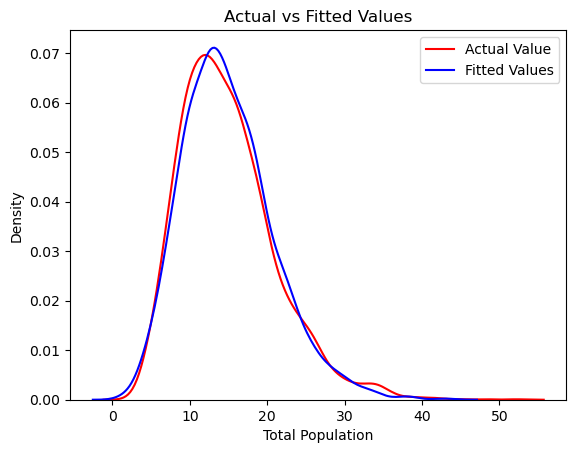

In [65]:
plt.figure()
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values')
plt.xlabel('Total Population')

plt.legend()

plt.show()
plt.close()

# Decision Tree

In [66]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state = 42)
model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=42)

In [67]:
y_pred =model.predict(X_test_scaled)

In [68]:
r2 = skl.metrics.r2_score(y_test, y_pred)
mse = skl.metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 

print("R-Squared Value:", round(r2, 4))
print("MSE:", round(mse, 4))
print("RMSE:",round(rmse, 4))

R-Squared Value: 0.8429
MSE: 5.9488
RMSE: 2.439


C:\Users\joshu\AppData\Local\Temp\ipykernel_9304\4149121072.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
C:\Users\joshu\AppData\Local\Temp\ipykernel_9304\4149121072.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dist

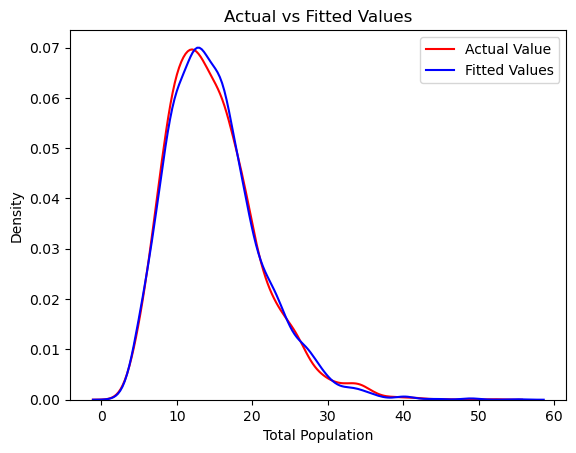

In [69]:
plt.figure()
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values')
plt.xlabel('Total Population')

plt.legend()

plt.show()
plt.close()

# Grid Search (RF Optimization)

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
RF_param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42]
}
RF_GridCV = GridSearchCV(RandomForestRegressor(), RF_param_grid, cv=5, n_jobs= -1)
RF_GridCV.fit(X_train_scaled,y_train)  
print(RF_GridCV.best_params_)    
print(RF_GridCV.best_score_)

c:\Users\joshu\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joshu\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joshu\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\joshu\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\User

{'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 42}
0.9284368795625568


# Random Forest

In [80]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 500,random_state = 42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [81]:
y_pred =model.predict(X_test_scaled)

In [82]:
r2 = skl.metrics.r2_score(y_test, y_pred)
mse = skl.metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 

print("R-Squared Value:", round(r2, 4))
print("MSE:", round(mse, 4))
print("RMSE:",round(rmse, 4))

R-Squared Value: 0.9278
MSE: 2.7333
RMSE: 1.6533


C:\Users\joshu\AppData\Local\Temp\ipykernel_9304\1398700974.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
C:\Users\joshu\AppData\Local\Temp\ipykernel_9304\1398700974.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dist

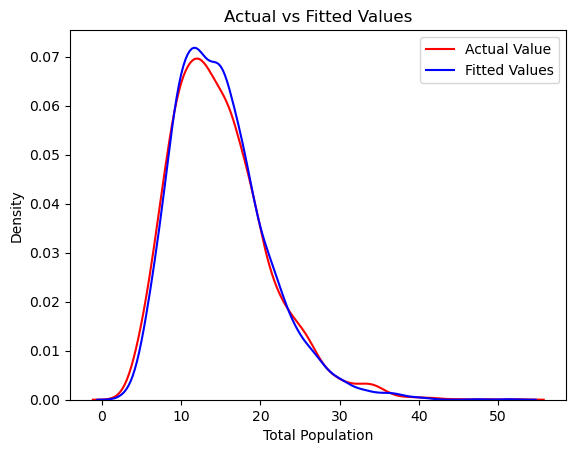

In [83]:
plt.figure()
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values')
plt.xlabel('Total Population')
plt.legend()

plt.show()
plt.close()

# Feature Importance

In [84]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_
# We can sort the features by their importance
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.8330082081577207, 'Child-poverty'),
 (0.0334900831181687, 'Median Household Income'),
 (0.019965700377075336, 'Per capita Income'),
 (0.009712864614106094, 'Population (16+)'),
 (0.008795206807190549, 'Construction (Occupation)'),
 (0.008257831768289583, 'Employed'),
 (0.007122832822399686, 'Graduate_degree'),
 (0.007113028543572965, 'Below_9th_grade'),
 (0.006056411006640645, "Gov't (Class)"),
 (0.004755051320996558, 'Professional (Occupation)'),
 (0.004632002723985336, 'White'),
 (0.004531922149891238, 'RaceOther'),
 (0.004385815712324334, 'Unemployment Rate'),
 (0.004256707190136722, 'Salary (Class)'),
 (0.004057080917340002, 'Total Population'),
 (0.0035024907173174576, 'Service (Occupation)'),
 (0.0034449122224894245, "Bachelor's_degree"),
 (0.003422454956781679, 'Production (Occupation)'),
 (0.0030606353807528536, 'Self-employed (Class)'),
 (0.002915974421206493, 'Median Mortgage'),
 (0.0028582161023585004, 'Median Home value'),
 (0.002659133387979865, 'Black'),
 (0.002607893

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

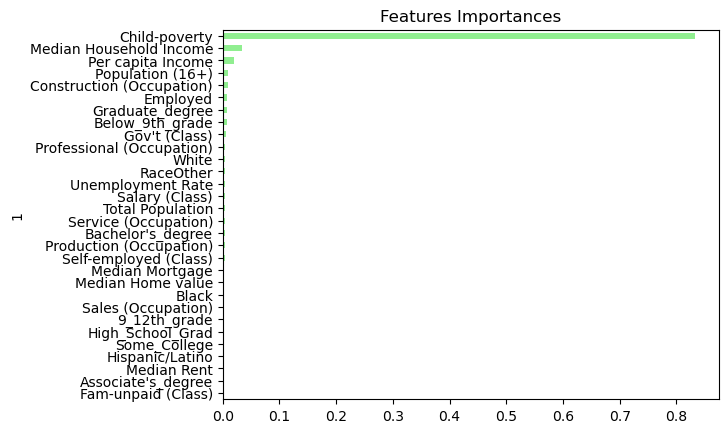

In [85]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Deep Neural Net

In [91]:
# Define the model
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  100
hidden_nodes_layer2 = 50
hidden_nodes_layer3 = 25

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features,activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

c:\Users\joshu\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 100)            │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,451 (36.92 KB)

 Trainable params: 9,451 (36.92 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Compile the model
nn.compile(loss="mse", optimizer="adam", metrics=["R2Score"])

In [93]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - R2Score: -4.9646 - loss: 230.5998
Epoch 2/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - R2Score: -4.8992 - loss: 228.7817
Epoch 3/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - R2Score: -4.8555 - loss: 230.1596
Epoch 4/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - R2Score: -5.0243 - loss: 227.2994
Epoch 5/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - R2Score: -4.9575 - loss: 229.0337
Epoch 6/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -4.9870 - loss: 226.2547  
Epoch 7/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - R2Score: -4.8347 - loss: 230.3687
Epoch 8/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -4.8589 - loss: 229.7662
Epoch 9/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - R2Score: -4.8619 - loss: 232.1738
Epoch 10/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - R2Score: -4.9733 - loss: 226.1533
Epoch 11/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -4.9924 - loss: 231.4475
E

KeyboardInterrupt: 